# Apply the H-Alpha dual-polarimetric decomposition to a Sentinel-1C product

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

import geopandas as gpd
from eodag import EODataAccessGateway

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
logging.basicConfig(level=logging.INFO)

## Set up parameters and output dir

In [2]:
# change to your custom locations
data_dir = "/data/S1"

ids = [
    "S1C_IW_SLC__1SDV_20250401T174601_20250401T174629_001703_002E2A_4DC9",
]
slc_path = f"{data_dir}/{ids[0]}.zip"
output_dir="/data/res/test-h-alpha-processor"

## Download S-1 products

In [ ]:
# load a geometry
aoi_file = "../data/Andorra_tiny.geojson"
shp = gpd.read_file(aoi_file).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2025-03-30",
    "end": "2025-04-30",
    "geom": shp
}

results = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
dag.download_all(to_dl, output_dir="/data/S1/", extract=False)

## Process data

In [ ]:
from eo_tools.S1.process import process_h_alpha_dual

out_dir_ha = process_h_alpha_dual(
    slc_path=slc_path,
    output_dir=output_dir,
    aoi_name="beta_cal",
    shp=shp,
    write_vv_amplitude=True,
    write_vh_amplitude=True,
    subswaths=["IW1", "IW2", "IW3"],
    dem_upsampling=1.8,
    dem_force_download=False,
    dem_buffer_arc_sec=40,
    multilook=[1, 4],
    warp_kernel="bicubic",
    cal_type="beta",
    clip_to_shape=False,
)

## Display results

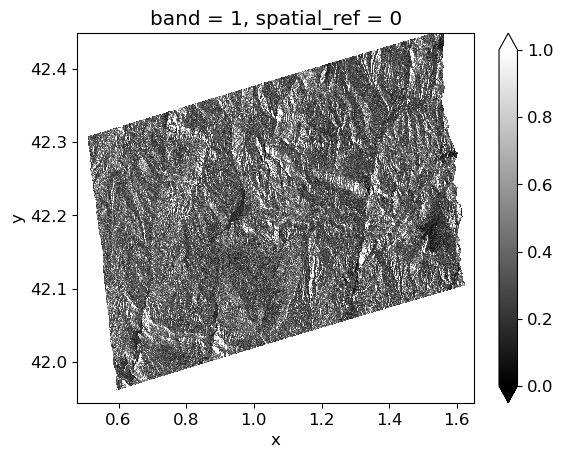

In [5]:
import rioxarray as riox
arr = riox.open_rasterio(f"{out_dir_ha}/amp_vv.tif", masked=True)[0]
arr.plot.imshow(vmin=0, vmax=1, cmap="gray")

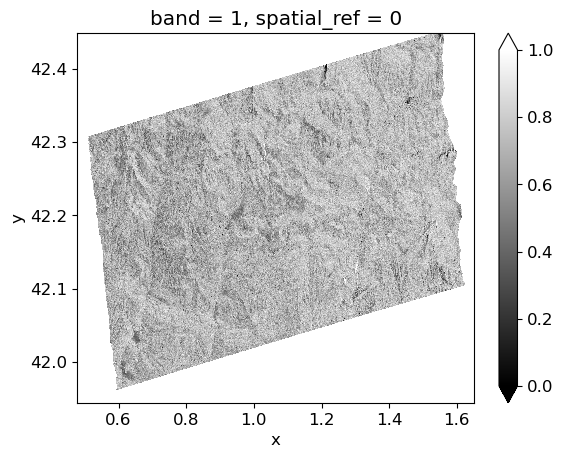

In [ ]:
arr = riox.open_rasterio(f"{out_dir_ha}/H.tif", masked=True)[0]
arr.plot.imshow(vmin=0, vmax=1, cmap="gray")

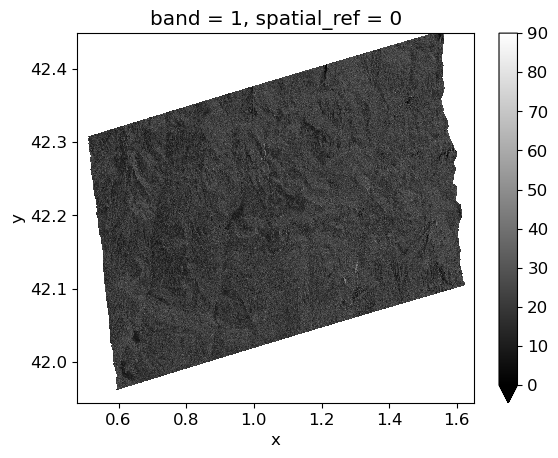

In [ ]:
arr = riox.open_rasterio(f"{out_dir_ha}/alpha.tif", masked=True)[0]
arr.plot.imshow(vmin=0, vmax=90, cmap="gray")